# NBA Analysis

In [1]:
# Importing all necessary comments
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from plotnine import *
from tabulate import tabulate
!pip install colorama
from colorama import Fore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Loading dataset
nba_draft = pd.read_csv("https://raw.githubusercontent.com/ryanking916/Data/main/nbaplayersdraft.csv")

## **Part 1: Data Comprehension**

### (A) Which NBA team(s) has drafted the most players who...
**a. Went to Duke and were drafted in or before the 2000 draft?**





In [3]:
# This code block determines the teams that have drafted the most players who went to Duke and were drafted in or before the 2000 draft

# Filters the dataset and selects players that meet the requirements
duke_players = nba_draft[(nba_draft['college'] == 'Duke') & (nba_draft['year'] <= 2000)]

teams = duke_players.groupby(['team']).size().reset_index(name='Count')

# Finds the max count of these specific players among all teams
max = teams['Count'].max()

# Puts the teams with the max number of these into a list
teams_with_max = teams[teams['Count'] == max].index.tolist()

# Print the results
print("The NBA teams that have drafted the most players who went to Duke and were drafted in or before the 2000 draft were: ")
for i in teams_with_max:
  print(teams['team'][i])

The NBA teams that have drafted the most players who went to Duke and were drafted in or before the 2000 draft were: 
DAL
MIN
PHO


**b. Have a first name that begins with D and were drafted in an even year draft?**

In [4]:
# This code block determines the NBA teams who have drafted the most players with a first name that begins with D and were drafted in an even year

# Filters the dataset and selects player with first name starting with D and that were drafted in even year
players = (nba_draft.loc[(nba_draft['player'].str[0] == 'D') & (nba_draft['year'] % 2 == 0)])

teams = players.groupby(['team']).size().reset_index(name='Count')

# Finds the max count of these specific players among all teams
max = teams['Count'].max()

# Put these teams with the max count in a list
teams_with_max = teams[teams['Count'] == max].index.tolist()

# Print the results
print("The NBA teams that have drafted the most players who have a first name that begins with D and were drafted in an even year draft were: ")
for i in teams_with_max:
  print(teams['team'][i])

The NBA teams that have drafted the most players who have a first name that begins with D and were drafted in an even year draft were: 
BOS
MIL
SEA


### (B) Describe the relationship between a team's first round pick slot in one year with their first-round pick slot in the subsequent year

In [5]:
# This function determines what round the player was drafted in. Takes a overall pick and year as parameters
def round_determiner(pick_num, year_num):
  if (year_num >= 1989 and year_num <= 1994) and (pick_num >= 1 and pick_num <= 27):
    return 1
  elif (year_num >= 1995 and year_num <= 2004) and (pick_num >= 1 and pick_num <= 29):
    return 1
  elif (year_num >= 2005 and year_num <= 2021) and (pick_num >= 1 and pick_num <= 30):
    return 1
  else:
    return 2

# This calls the function above for each overall pick in the dataset
nba_draft['Round'] = nba_draft.apply(lambda row: round_determiner(row['overall_pick'], row['year']), axis = 1)

# Determines the first round picks
first_round_slots = nba_draft[['year', 'overall_pick', 'Round', 'team']]
first_round_slots = first_round_slots[first_round_slots['Round'] == 1]

# Groups the data by team and year then calculates average draft pick slot
team_pick_slots = first_round_slots.groupby(['team', 'year']).mean()['overall_pick'].reset_index()

# Creates a new column to represent the subsequent year pick for each team
team_pick_slots['Subsequent_Year_Pick'] = team_pick_slots.groupby('team')['overall_pick'].shift(-1)

# Calculates the correlation coefficient between a team's first round pick slot in one year and their first round pick slot in the next year
correlation = team_pick_slots['overall_pick'].corr(team_pick_slots['Subsequent_Year_Pick'])

# Print the results
print("The Correlation Coefficient between a team's first-round pick slot in one year and their first round pick slot in the subsequent year is ")
print(round(correlation, 3))


The Correlation Coefficient between a team's first-round pick slot in one year and their first round pick slot in the subsequent year is 
0.419


A correlation coefficient of 0.419 indicates that there is a positive correlation between the two variables. Having a positive correlation in this situation means that as the first-round slot in one year increases, the first-round pick slot in the next year also tends to increase. However, the correlation coefficient value of 0.419 is fairly moderate in strength, which means there is a relationship between the two variables, but it is not a strong relationship. There are likely other factors that contribute to a team's draft position in subsequent years. In actual terms, this positive correlation suggests that teams with higher first-round pick slots in one year are more likely to have higher pick slots in the next year. This could be due to factors like trades, free agent signings, team performance, or draft techniques employed by the teams.

## **Part 2: Analytical Acumen**

### (A) Prompt: Analyze draft position value and team success/deficiencies compared to expectation.
**a. Create a method for valuing each draft slot in the NBA Draft (picks 1 through 60 in most drafts)**

In [6]:
# Getting rid of values that do not contain necessary performance metrics
columns = ['value_over_replacement', 'win_shares', 'box_plus_minus']
nba_draft = nba_draft.dropna(subset=columns)

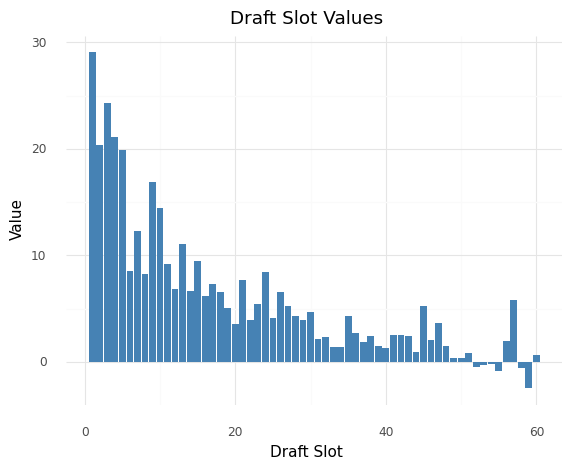

<ggplot: (8731821428764)>

In [7]:
# This is a function for assigning a value to each draft slot from a given dataset
def valuing_draft_slots(draft_data):
  vor_weight = (1/3.0)
  ws_weight = (1/3.0)
  bpm_weight = (1/3.0)

  # Create a dictionary to store the draft position values
  draft_values = {}

  # Iterate through the nba_draft dataset
  for pick in range(1,61):
      pick_numbers = draft_data[(draft_data['year'] >= 1989) & (draft_data['year'] <= 2021) & (draft_data['overall_pick'] == pick)]

      slot_value = (pick_numbers['value_over_replacement'].mean() * vor_weight) + (pick_numbers['win_shares'].mean() * ws_weight) + (pick_numbers['box_plus_minus'].mean() * bpm_weight)

    # Assign the calculated value to the draft position in the draft_values dictionary
      draft_values[pick] = slot_value

  return draft_values

draft_slot_values = valuing_draft_slots(nba_draft)

new_df = pd.DataFrame({'Draft Pick': list(draft_slot_values.keys()), 'Value': list(draft_slot_values.values())})

# Printing the table
ggplot(new_df, aes(x='Draft Pick', y='Value')) + \
    geom_bar(stat='identity', fill='steelblue') + \
    theme_minimal() + labs(x='Draft Slot', y='Value', title='Draft Slot Values')





**b. Conditional on the expected value of the draft positions, which NBA teams have over or underperformed the most when drafting during this time span. 
Which College Teams have had the players outperform expectations the most after entering the NBA?**

In [16]:
# This code block assesses an NBA teams performance and compares it to the draft position value from the previous question
nba_team_performance = {}

# Iterate over the draft data
for _, player in nba_draft.iterrows():
    team = player['team']
    draft_position = player['overall_pick']
    actual_performance = (player['value_over_replacement'] * (1/3.0)) + (player['win_shares'] * (1/3.0)) + (player['box_plus_minus'] * (1/3.0))

    # Calculate the expected value for the draft position given what was found in previous question
    expected_value = draft_slot_values[draft_position]

    # Calculate the performance difference
    performance_difference = actual_performance - expected_value

    # Update the performance metrics for NBA teams
    if team in nba_team_performance:
        nba_team_performance[team].append(performance_difference)
    else:
        nba_team_performance[team] = [performance_difference]

# Calculate the average performance difference for each NBA team
average_performance_diff = {}
for team, performance_diff_list in nba_team_performance.items():
    average_diff = sum(performance_diff_list) / len(performance_diff_list)
    average_performance_diff[team] = average_diff

# Calculate the overall average performance difference
overall_average_diff = sum(average_performance_diff.values()) / len(average_performance_diff)

# Sort the teams based on the difference from the overall average
overperforming_teams = sorted(average_performance_diff, key=lambda x: average_performance_diff[x] - overall_average_diff, reverse=True)
underperforming_teams = sorted(average_performance_diff, key=lambda x: average_performance_diff[x] - overall_average_diff)

# Create a list of table rows color coded with team names and performance differences
table_data_overperforming = []
table_data_underperforming = []
for team in overperforming_teams:
    diff = average_performance_diff[team] - overall_average_diff
    if diff > 0:
        table_data_overperforming.append([Fore.BLUE + team + Fore.RESET, f"{diff:.3f}"])

for team in underperforming_teams:
    diff = average_performance_diff[team] - overall_average_diff
    if diff < 0:
        table_data_underperforming.append([Fore.RED + team + Fore.RESET, f"{diff:.3f}"])

# Sort the table data based on the performance difference from greatest to least
table_data_overperforming.sort(key=lambda x: float(x[1]), reverse=True)
table_data_underperforming.sort(key=lambda x: float(x[1]), reverse=True)
title = "Overperforming NBA Teams"

# Print the table
headers_op = ["Overperforming NBA Teams", "Performance Difference"]
headers_up = ["Underperforming NBA Teams", "Performance Difference"]

print(tabulate(table_data_overperforming, headers=headers_op, tablefmt="fancy grid"))
print()
print(tabulate(table_data_underperforming, headers=headers_up, tablefmt="fancy grid"))

Overperforming NBA Teams      Performance Difference
--------------------------  ------------------------
NOH                                           11.296
SEA                                            6.443
SAS                                            4.605
CHH                                            2.425
CLE                                            1.745
IND                                            1.653
TOR                                            1.624
HOU                                            1.615
GSW                                            1.465
LAL                                            1.445
DEN                                            1.412
MIL                                            0.852
DET                                            0.381
MEM                                            0.229
MIA                                            0.137
PHO                                            0.111
UTA                                           

In [11]:
# This code block determines which college teams have had players outperform expectations most after entering the NBA
college_performance_diff = {}

# Iterate over the draft data
for _, player in nba_draft.iterrows():
    college_team = player['college']
    actual_performance = (player['value_over_replacement'] * (1/3.0)) + (player['win_shares'] * (1/3.0)) + (player['box_plus_minus'] * (1/3.0))

    # Calculate the expected value based on draft position
    draft_position = player['overall_pick']
    expected_value = draft_slot_values[draft_position]

    # Calculate the performance difference
    performance_difference = actual_performance - expected_value

    # Update the performance metrics for college teams
    if college_team in college_performance_diff:
        college_performance_diff[college_team].append(performance_difference)
    else:
        college_performance_diff[college_team] = [performance_difference]

# Create a dictionary to store average performance difference for every college team
average_performance_diff = {}

# Calculate average difference for each college team in the dataset
for college_team, performance_diff_list in college_performance_diff.items():
    average_diff = sum(performance_diff_list) / len(performance_diff_list)
    average_performance_diff[college_team] = average_diff

# Sort the teams based on the performance difference they have
sorted_college_teams = sorted(average_performance_diff, key=lambda x: average_performance_diff[x] - overall_average_diff, reverse=True)

# Creating a table to store the data found
table_data = []

for i, college_team in enumerate(sorted_college_teams[:25], start=1):
    diff = average_performance_diff[college_team] - overall_average_diff
    table_data.append([i, college_team, f"{diff:.3f}"])

# Print the table
headers = ["Rank", "College Team", "Performance Metric"]
print(tabulate(table_data, headers=headers, tablefmt="fancy grid"))


  Rank  College Team                           Performance Metric
------  -----------------------------------  --------------------
     1  Santa Clara                                        50.972
     2  Davidson                                           50.414
     3  Trinity Valley CC                                  29.334
     4  IUPUI                                              23.465
     5  Louisiana Tech                                     20.124
     6  Weber State                                        19.906
     7  Wake Forest                                        17.174
     8  Rhode Island                                       16.226
     9  Saint Mary's                                       15.786
    10  Little Rock                                        15.152
    11  Miami University                                   14.115
    12  Butler County Community College                    13.227
    13  Morehead State University                          11.831
    14  Ja

**c. Explain and present your findings with tables and visuals. What additional research areas would you focus on if given the opportunity to expand this study?**

The tables and visuals are displayed above. A more detailed analysis of these findings can be found in the final report. 


Some additional research areas I would focus on if given the opportunity I would complete a more thorough examination of why certain NBA teams are having more success when it comes to drafting than others. There could be many factors that affect their success so it would be interesting to identify those and see how they impact the upcoming NBA draft. Another area that draws my interest is to evaluate how a teams overall success correlates with the quality of players drafted over the time period in the dataset. This could reveal draft trends and strategies that produce better team performance outcomes. It also allows me to explore whether certain teams are consistently drafting players with specific skill sets or from particular colleges, and we can see if these techniques are working for the teams.

In [1]:
# List of Resources

# 1. https://pypi.org/project/tabulate/
# 2. https://www.datacamp.com/tutorial/pandas-apply
# 3. https://www.datacamp.com/tutorial/role-underscore-python
# 4. https://www.geeksforgeeks.org/pandas-dataframe-iterrows-function-in-python/
